# Resonant Triad
The basic governing equations for a resonant triad has the form, 
$$
\dot{z_1} = i\omega_1z_1 + \epsilon C_1z_2^*z_3^*\\
\dot{z_2} = i\omega_2z_2 + \epsilon C_2z_1^*z_3^*\\
\dot{z_3} = i\omega_3z_3 + \epsilon C_3z_1^*z_2^*.
$$

In addition, we assume $C_1+C_2+C_3=0$ and $\omega_1 + \omega_2+\omega_3 = 0$.

## Four integrating methods
In this notebook, we will compare four different time-stepping methods.
For $i = 1, 2, 3$, let $j$ and $k$ represent the other two, i.e.  i = 1 implies j = 2, k = 3 or j = 3, k=2.
### Integrating-Factor-Euler (IF-Euler)
$$
z_i^{n+1} = e^{i\omega_i\Delta_t}z_i^n + \epsilon C_1 \Delta_t e^{i\omega_i\Delta_t}(z_j^n)^*(z_k^n)^*
$$

### Exponential Time Differencing (ETD)
In particular, we consider the simplest ETD scheme,  ETD1 (Cox & Matthews)
$$
z_i^{n+1} = e^{i\omega_i\Delta_t}z_i^n + \epsilon C_i \Delta_t \phi(i\omega_i\Delta_t)(z_j^n)^*(z_k^n)^*,
$$
where $\phi(A) = \frac{e^A-1}{A}$.

### IMEX-Euler (IMEX-E)
IMEX schemes solve the linear portions implicitly, and the nonlinear portions explicitly.
In IMEX-Euler, the explicit nonlinearity is dealth with forward Euler.
$$
z_i^{n+1} = z_i^n + \Delta_t[i\omega_iz_i^{n+1} + \epsilon C_i \Delta_t (z_j^n)^*(z_k^n)^*]
$$

### IMEX-Crank-Nicholson (IMEX-CN)
In IMEX-CN, the linear part is implicitly computed with Crank-Nicholson, and nonlinearity is dealt with forward Euler.
?There is no dissipative errors (in the amplitude), but dispersive errors exist. 
$$
z_i^{n+1} = z_i^n + \Delta_t[i\omega_i\frac{z_i^{n+1}+z_i^n}{2} + \epsilon C_i \Delta_t(z_j^n)^*(z_k^n)^*]
$$

In [1]:
# This files includes many possible time integrating methods coded for resonant triads...
# as well as functions that help set up the resonant triad conditions...
# and functions that write the amplitude of each of the 3 waves at each time step.
include("../codes/RT.jl")
seed=1205
Random.seed!(seed);

### Equation parameters
Let us set $\epsilon=0.01$ and $\omega = [-1, 3, -2]$.
$C_1$, $C_2$, and $C_3$ are set to be random floats that add to zero, and have absolute magnitude lesser than or equal to 5.

In [2]:
ϵ = 0.01;        # Nonlinear scale
ω = [-1, 3, -2]; # "slow" wave numbers
C = floatRT(5) # Energy conserving constants
C

3-element Array{Float64,1}:
  1.3140801486467968
 -4.619852488888716 
  3.3057723402419192

### Time-stepper parameters
We need to run this system of ODEs for at least $T=1/\epsilon$.
    Since our goal is to test for time step sizes that are larger than the slowest fast wave number, we want to approximately set $h\geq 1/\omega$.

In [3]:
IC = onUnitCircle(3) # Initial condition
T=1000;               # Final time
L=1000;               # Number of state/amplitudes to save
IC

3-element Array{Complex{Float64},1}:
 -0.7339813089780982 + 0.6791696681027485im
   -0.57666564957615 + 0.816980249821816im 
  0.8320766951772831 + 0.5546605929240428im

#### We will use RK4 with a very small time-step to generate our ground truth solution. 

In [4]:
name="true_seed"*string(seed); 
h=exp10(-5);           # time step size
N = Int(ceil(T/h));    # Number of time-steps to get to T
every = Int(ceil(N/L)) # only save L+1 values total
#RT_amp(N, h, every, IC, ω=ω, ϵ=ϵ, C=C, stepper=RK4, name=name);

### Compare methods

In [5]:
steppers = [IFE, ETD1, CNimex, EUimex, IFRK2, IFRK4]
ss = length(steppers)
h = 0.2 # Time-step
for j = 1 : ss
	txtname=string(steppers[j])*"h="*string(h)*"seed"*string(seed)
	N = Int(ceil(T/h)); 
    every = Int(ceil(N/L));
	RT_amp(N, h, every, IC, ω=ω, ϵ=ϵ, C=C, stepper=steppers[j], name=txtname);
end

## PLOT

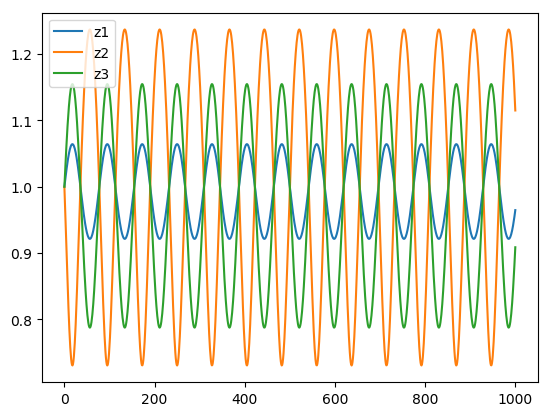

PyObject <matplotlib.legend.Legend object at 0x1414900b8>

In [6]:
# "True" solution
tsol = readdlm("../txtfiles/true_seed"*string(seed)*".txt")
using PyPlot
plot(tsol[:,1], label="z1")
plot(tsol[:,2], label="z2")
plot(tsol[:,3], label="z3")
legend()

In [7]:
sol = Array{Array{Float64,2},1}(undef,ss+2);
for i = 1 : ss
    sol[i] = readdlm("../txtfiles/"*string(steppers[i])*"h="*string(h)*"seed"*string(seed)*".txt")
end

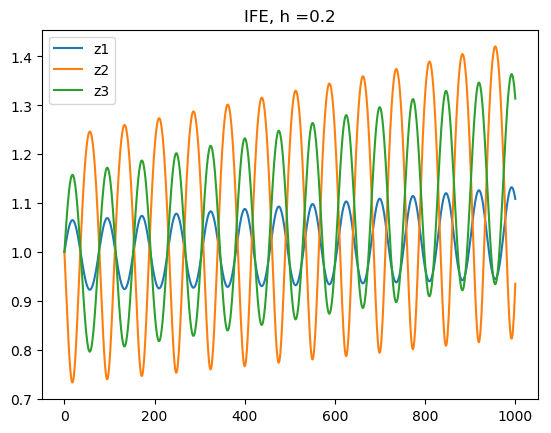

PyObject <matplotlib.legend.Legend object at 0x141b77c88>

In [10]:
plot(sol[1][:,1], label="z1")
plot(sol[1][:,2], label="z2")
plot(sol[1][:,3], label="z3")
title(string(steppers[1])*", h ="*string(h))
legend()

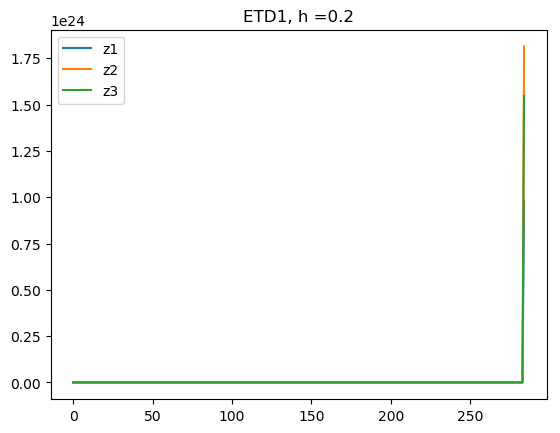

PyObject <matplotlib.legend.Legend object at 0x141cddf98>

In [11]:
plot(sol[2][:,1], label="z1")
plot(sol[2][:,2], label="z2")
plot(sol[2][:,3], label="z3")
title(string(steppers[2])*", h ="*string(h))
legend()

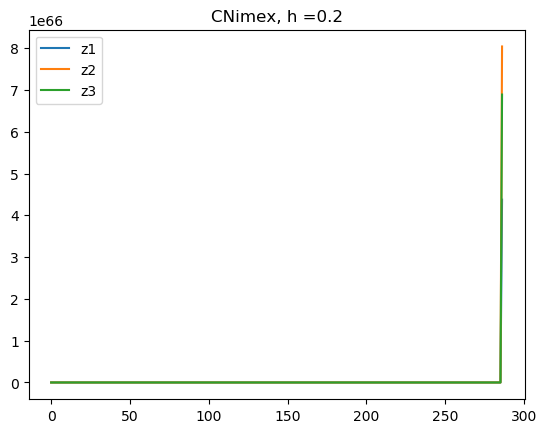

PyObject <matplotlib.legend.Legend object at 0x141e91320>

In [12]:
plot(sol[3][:,1], label="z1")
plot(sol[3][:,2], label="z2")
plot(sol[3][:,3], label="z3")
title(string(steppers[3])*", h ="*string(h))
legend()

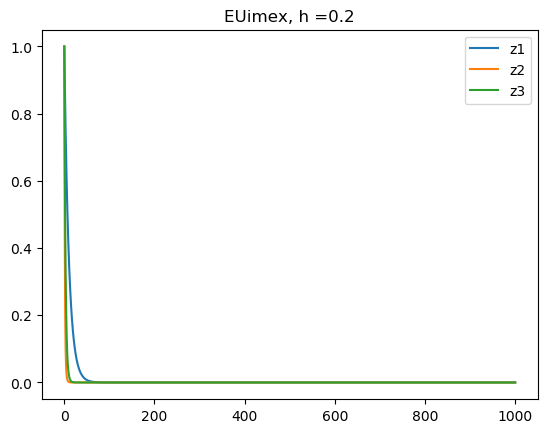

PyObject <matplotlib.legend.Legend object at 0x141ff9da0>

In [13]:
plot(sol[4][:,1], label="z1")
plot(sol[4][:,2], label="z2")
plot(sol[4][:,3], label="z3")
title(string(steppers[4])*", h ="*string(h))
legend()

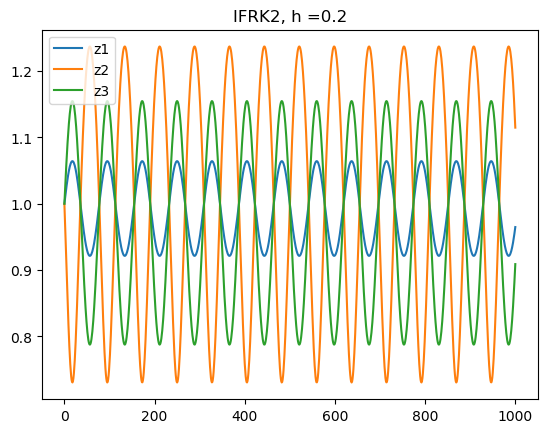

PyObject <matplotlib.legend.Legend object at 0x14214e978>

In [14]:
plot(sol[5][:,1], label="z1")
plot(sol[5][:,2], label="z2")
plot(sol[5][:,3], label="z3")
title(string(steppers[5])*", h ="*string(h))
legend()

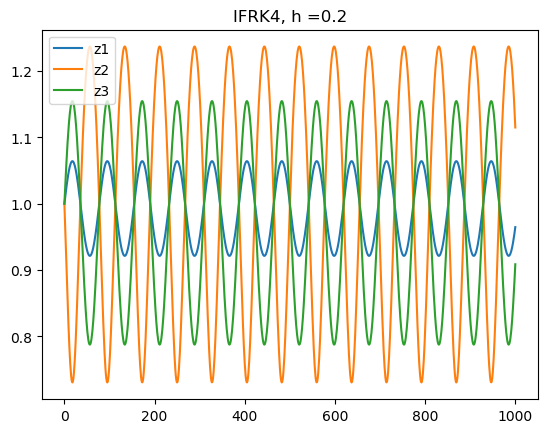

PyObject <matplotlib.legend.Legend object at 0x14229ae10>

In [15]:
plot(sol[6][:,1], label="z1")
plot(sol[6][:,2], label="z2")
plot(sol[6][:,3], label="z3")
title(string(steppers[6])*", h ="*string(h))
legend()

### Since RK2 and RK4 evaluate the nonlinear portion more often, let's look at even larger time-steps. 

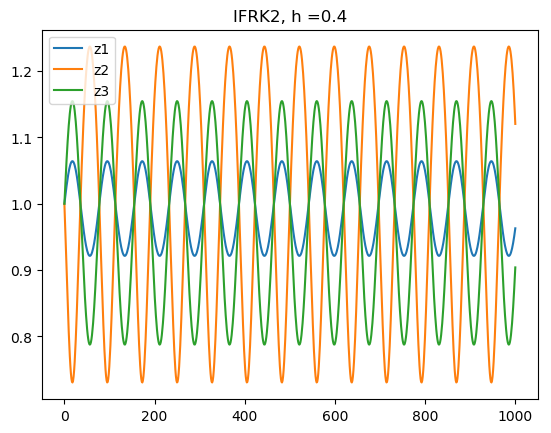

PyObject <matplotlib.legend.Legend object at 0x1423f1dd8>

In [16]:
j = 5
h = 0.4
txtname=string(steppers[j])*"h="*string(h)*"seed"*string(seed)
N = Int(ceil(T/h)); 
every = Int(ceil(N/L));
RT_amp(N, h, every, IC, ω=ω, ϵ=ϵ, C=C, stepper=steppers[j], name=txtname);

solRK2 = readdlm("../txtfiles/"*string(steppers[j])*"h="*string(h)*"seed"*string(seed)*".txt");
trange = range(0, T, length=size(solRK2)[1])
plot(trange, solRK2[:,1], label="z1")
plot(trange, solRK2[:,2], label="z2")
plot(trange, solRK2[:,3], label="z3")
title(string(steppers[j])*", h ="*string(h))
legend()

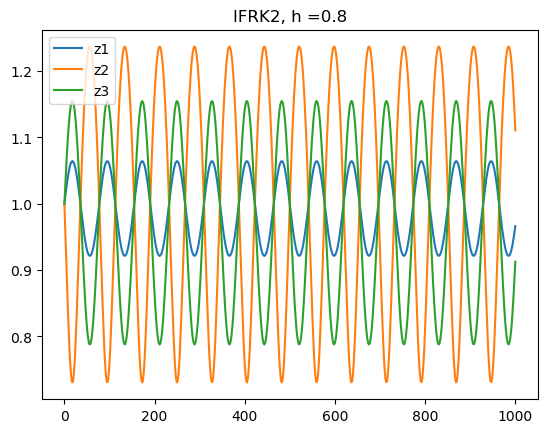

PyObject <matplotlib.legend.Legend object at 0x14240cf98>

In [17]:
j = 5
h = 0.8
txtname=string(steppers[j])*"h="*string(h)*"seed"*string(seed)
N = Int(ceil(T/h)); 
every = Int(ceil(N/L));
RT_amp(N, h, every, IC, ω=ω, ϵ=ϵ, C=C, stepper=steppers[j], name=txtname);

solRK2 = readdlm("../txtfiles/"*string(steppers[j])*"h="*string(h)*"seed"*string(seed)*".txt");
trange = range(0, T, length=size(solRK2)[1])
plot(trange, solRK2[:,1], label="z1")
plot(trange, solRK2[:,2], label="z2")
plot(trange, solRK2[:,3], label="z3")
title(string(steppers[j])*", h ="*string(h))
legend()

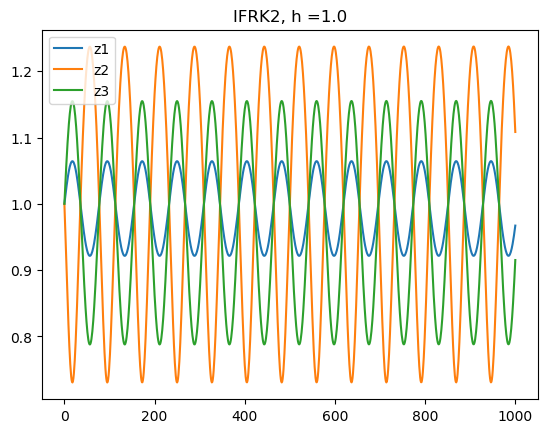

PyObject <matplotlib.legend.Legend object at 0x142710198>

In [18]:
j = 5
h = 1.0
txtname=string(steppers[j])*"h="*string(h)*"seed"*string(seed)
N = Int(ceil(T/h)); 
every = Int(ceil(N/L));
RT_amp(N, h, every, IC, ω=ω, ϵ=ϵ, C=C, stepper=steppers[j], name=txtname);

solRK2 = readdlm("../txtfiles/"*string(steppers[j])*"h="*string(h)*"seed"*string(seed)*".txt");
trange = range(0, T, length=size(solRK2)[1])
plot(trange, solRK2[:,1], label="z1")
plot(trange, solRK2[:,2], label="z2")
plot(trange, solRK2[:,3], label="z3")
title(string(steppers[j])*", h ="*string(h))
legend()

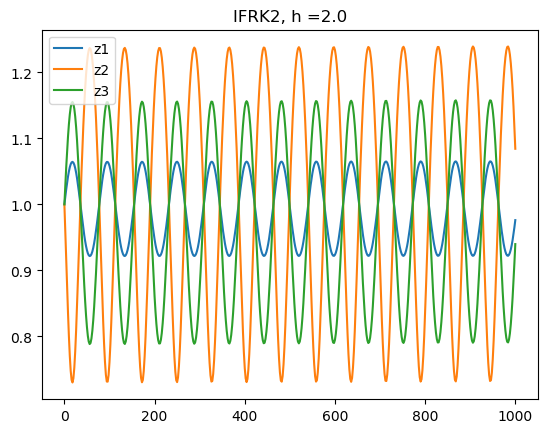

PyObject <matplotlib.legend.Legend object at 0x142896630>

In [19]:
j = 5
h = 2.0
txtname=string(steppers[j])*"h="*string(h)*"seed"*string(seed)
N = Int(ceil(T/h)); 
every = Int(ceil(N/L));
RT_amp(N, h, every, IC, ω=ω, ϵ=ϵ, C=C, stepper=steppers[j], name=txtname);

solRK2 = readdlm("../txtfiles/"*string(steppers[j])*"h="*string(h)*"seed"*string(seed)*".txt");
trange = range(0, T, length=size(solRK2)[1])
plot(trange, solRK2[:,1], label="z1")
plot(trange, solRK2[:,2], label="z2")
plot(trange, solRK2[:,3], label="z3")
title(string(steppers[j])*", h ="*string(h))
legend()

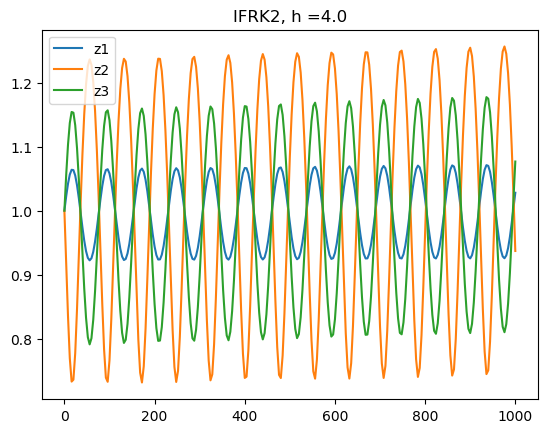

PyObject <matplotlib.legend.Legend object at 0x1428345c0>

In [20]:
j = 5
h = 4.0
txtname=string(steppers[j])*"h="*string(h)*"seed"*string(seed)
N = Int(ceil(T/h)); 
every = Int(ceil(N/L));
RT_amp(N, h, every, IC, ω=ω, ϵ=ϵ, C=C, stepper=steppers[j], name=txtname);

solRK2 = readdlm("../txtfiles/"*string(steppers[j])*"h="*string(h)*"seed"*string(seed)*".txt");
trange = range(0, T, length=size(solRK2)[1])
plot(trange, solRK2[:,1], label="z1")
plot(trange, solRK2[:,2], label="z2")
plot(trange, solRK2[:,3], label="z3")
title(string(steppers[j])*", h ="*string(h))
legend()

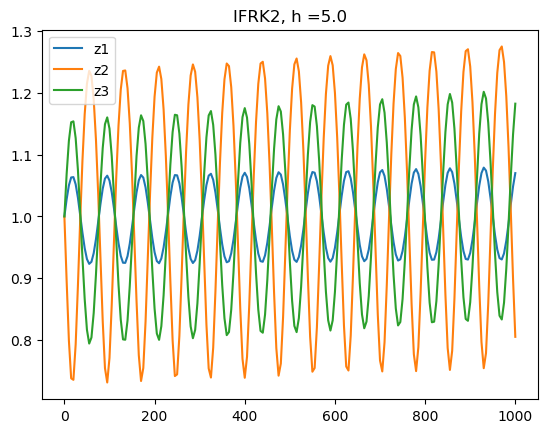

PyObject <matplotlib.legend.Legend object at 0x142bad9b0>

In [21]:
j = 5
h = 5.0
txtname=string(steppers[j])*"h="*string(h)*"seed"*string(seed)
N = Int(ceil(T/h)); 
every = Int(ceil(N/L));
RT_amp(N, h, every, IC, ω=ω, ϵ=ϵ, C=C, stepper=steppers[j], name=txtname);

solRK2 = readdlm("../txtfiles/"*string(steppers[j])*"h="*string(h)*"seed"*string(seed)*".txt");
trange = range(0, T, length=size(solRK2)[1])
plot(trange, solRK2[:,1], label="z1")
plot(trange, solRK2[:,2], label="z2")
plot(trange, solRK2[:,3], label="z3")
title(string(steppers[j])*", h ="*string(h))
legend()

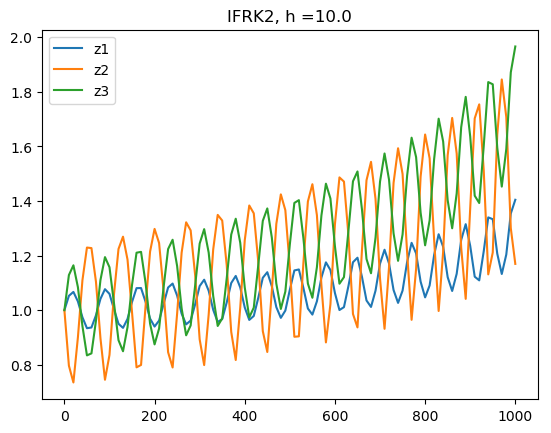

PyObject <matplotlib.legend.Legend object at 0x142d092b0>

In [22]:
j = 5
h = 10.0
txtname=string(steppers[j])*"h="*string(h)*"seed"*string(seed)
N = Int(ceil(T/h)); 
every = Int(ceil(N/L));
RT_amp(N, h, every, IC, ω=ω, ϵ=ϵ, C=C, stepper=steppers[j], name=txtname);

solRK2 = readdlm("../txtfiles/"*string(steppers[j])*"h="*string(h)*"seed"*string(seed)*".txt");
trange = range(0, T, length=size(solRK2)[1])
plot(trange, solRK2[:,1], label="z1")
plot(trange, solRK2[:,2], label="z2")
plot(trange, solRK2[:,3], label="z3")
title(string(steppers[j])*", h ="*string(h))
legend()

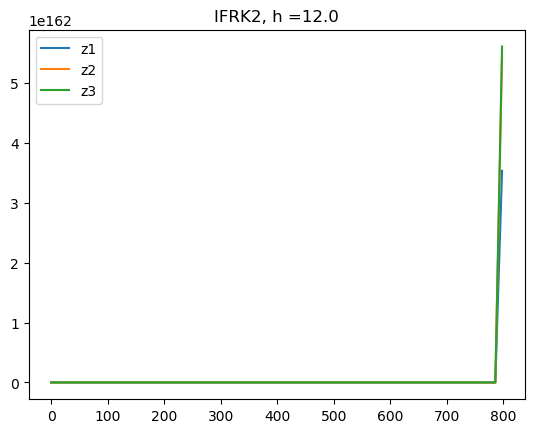

PyObject <matplotlib.legend.Legend object at 0x142eac978>

In [23]:
j = 5
h = 12.0
txtname=string(steppers[j])*"h="*string(h)*"seed"*string(seed)
N = Int(ceil(T/h)); 
every = Int(ceil(N/L));
RT_amp(N, h, every, IC, ω=ω, ϵ=ϵ, C=C, stepper=steppers[j], name=txtname);

solRK2 = readdlm("../txtfiles/"*string(steppers[j])*"h="*string(h)*"seed"*string(seed)*".txt");
trange = range(0, T, length=size(solRK2)[1])
plot(trange, solRK2[:,1], label="z1")
plot(trange, solRK2[:,2], label="z2")
plot(trange, solRK2[:,3], label="z3")
title(string(steppers[j])*", h ="*string(h))
legend()